In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [8]:
# Directories for training, validation, and testing
train_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/1.train"
val_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/2.val"
test_dir = "/kaggle/input/iris-data/Retinal fundus images for DR/3.test"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation & Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Swin Transformer Model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    training_time = time.time() - start_time
    return training_time

training_time = train_model(model, train_loader, val_loader, criterion, optimizer)

# Evaluating the Model
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, val_loader)
class_labels = train_dataset.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1, Loss: 1.4317
Epoch 2, Loss: 0.7861
Epoch 3, Loss: 0.4989
Epoch 4, Loss: 0.4216
Epoch 5, Loss: 0.2744
Epoch 6, Loss: 0.2142
Epoch 7, Loss: 0.1557
Epoch 8, Loss: 0.1396
Epoch 9, Loss: 0.1064
Epoch 10, Loss: 0.1022
Classification Report:
                         precision    recall  f1-score   support

         1. No DR signs       0.89      0.86      0.87        28
2. Mild (or early) NPDR       1.00      1.00      1.00        24
       3. Moderate NPDR       0.70      0.58      0.64        12
         4. Severe NPDR       0.86      0.92      0.89        26
    5. Very Severe NPDR       0.71      0.75      0.73        16
                 6. PDR       0.69      0.85      0.76        13
        7. Advanced PDR       0.86      0.71      0.77        17

               accuracy                           0.84       136
              macro avg       0.81      0.81      0.81       136
           weighted avg       0.84      0.84      0.84       136



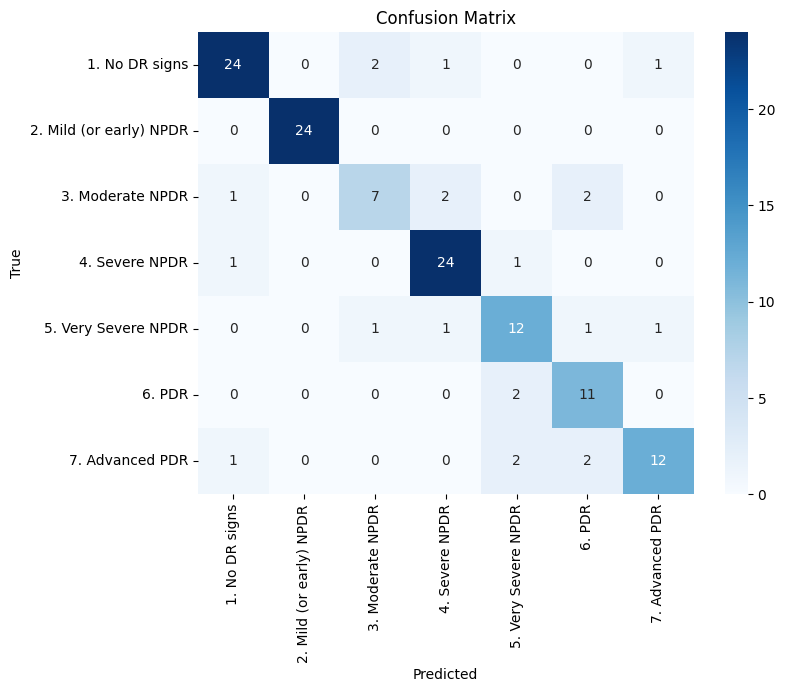

Training Time: 449.69 seconds
Accuracy: 0.8382
Precision: 0.8138
Recall (Sensitivity): 0.8094
F1-Score: 0.8083
Specificity: 0.9681


In [9]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")